# Plot clustermatch results

The input to clustermatch was k-mer abundances that had been MR-normalized, logged, and filtered to k-mers that were present in at least 50 samples.

In [1]:
setwd("..")

In [2]:
# change default figure size
options(repr.plot.width=15, repr.plot.height=7)
# disable scientific notation (for plot axes)
options(scipen = 999)

In [4]:
library(readr)
library(dplyr)
library(tibble)
library(tidyr)
library(purrr)
library(ggplot2)
library(data.table)

## Read in clustermatch results

In [5]:
clustermatch <- read_tsv("~/Downloads/cm-pa14_mrnorm_hlog_kmers_filt50.tsv", show_col_types = F)

In [6]:
clustermatch_long <- melt(as.data.table(clustermatch), id.vars = "minhash")

In [7]:
clustermatch_long <- clustermatch_long %>%
  mutate(variable = as.numeric(as.character(variable))) %>%
  filter(minhash != variable)

In [8]:
head(clustermatch_long)

minhash,variable,value
<dbl>,<dbl>,<dbl>
7037975305246,6420423175363,0.33252
8687411883152,6420423175363,0.33426
12877586329792,6420423175363,0.43772
18650490225240,6420423175363,0.43772
21174142004736,6420423175363,0.44752
21968976672722,6420423175363,0.32021


## Read in hash map and label with operons

In [9]:
pa14_hash_map <- read_csv("outputs/txomes_sourmash_sketch_singleton/pa14.csv", show_col_types = F)

In [10]:
pa14_operons <- read_csv("https://raw.githubusercontent.com/greenelab/core-accessory-interactome/master/data/metadata/PA14-operons-2021-07-19.csv", show_col_types = F)

`curl` package not installed, falling back to using `url()`


In [11]:
pa14_transcript_to_gene <- read_csv("https://osf.io/ema5c/download", skip = 1, col_names = c("tmp", "transcript_name", "locus_tag"), show_col_types = F) %>%
  select(-tmp)

`curl` package not installed, falling back to using `url()`


In [12]:
pa14_hash_map <- pa14_hash_map %>%
  mutate(transcript_name = gsub(" .*", "", name)) %>%
  left_join(pa14_transcript_to_gene, by = "transcript_name") %>%
  left_join(pa14_operons, by = "locus_tag")

In [13]:
pa14_hash_map_operon <- pa14_hash_map %>%
  filter(!is.na(`operon-id`))

pa14_hash_map_operon_small <- pa14_hash_map_operon %>%
  select(minhash, operon_id = `operon-id`) %>%
  distinct()

## Plot results

In [14]:
# add operon metadata and plot
clustermatch_df <- clustermatch_long %>%
  left_join(pa14_hash_map_operon_small, by = c("minhash" = "minhash")) %>% # determine which operon, if any, the row is part of
  select(minhash, variable, value, operon_id_row = operon_id) %>% # record operon identity of row
  left_join(pa14_hash_map_operon_small, by = c("variable" = "minhash")) %>% # determine which operon the col is part of
  select(minhash, variable, value, operon_id_row, operon_id_col = operon_id) %>% # record operon identity of col
  mutate(operon = ifelse(operon_id_row == operon_id_col, "operon pair", "not operon pair")) %>% # label operon pairs
  mutate(operon = ifelse(is.na(operon), "not operon pair", operon))

In [15]:
head(clustermatch_df, n = 20)

minhash,variable,value,operon_id_row,operon_id_col,operon
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
7037975305246,6420423175363,0.33252,operon-9576,operon-10084,not operon pair
8687411883152,6420423175363,0.33426,NA,operon-10084,not operon pair
12877586329792,6420423175363,0.43772,NA,operon-10084,not operon pair
18650490225240,6420423175363,0.43772,NA,operon-10084,not operon pair
21174142004736,6420423175363,0.44752,operon-9299,operon-10084,not operon pair
21174142004736,6420423175363,0.44752,operon-9505,operon-10084,not operon pair
21968976672722,6420423175363,0.32021,NA,operon-10084,not operon pair
34281120837322,6420423175363,0.37668,operon-9954,operon-10084,not operon pair
36978091431750,6420423175363,0.45742,operon-10005,operon-10084,not operon pair


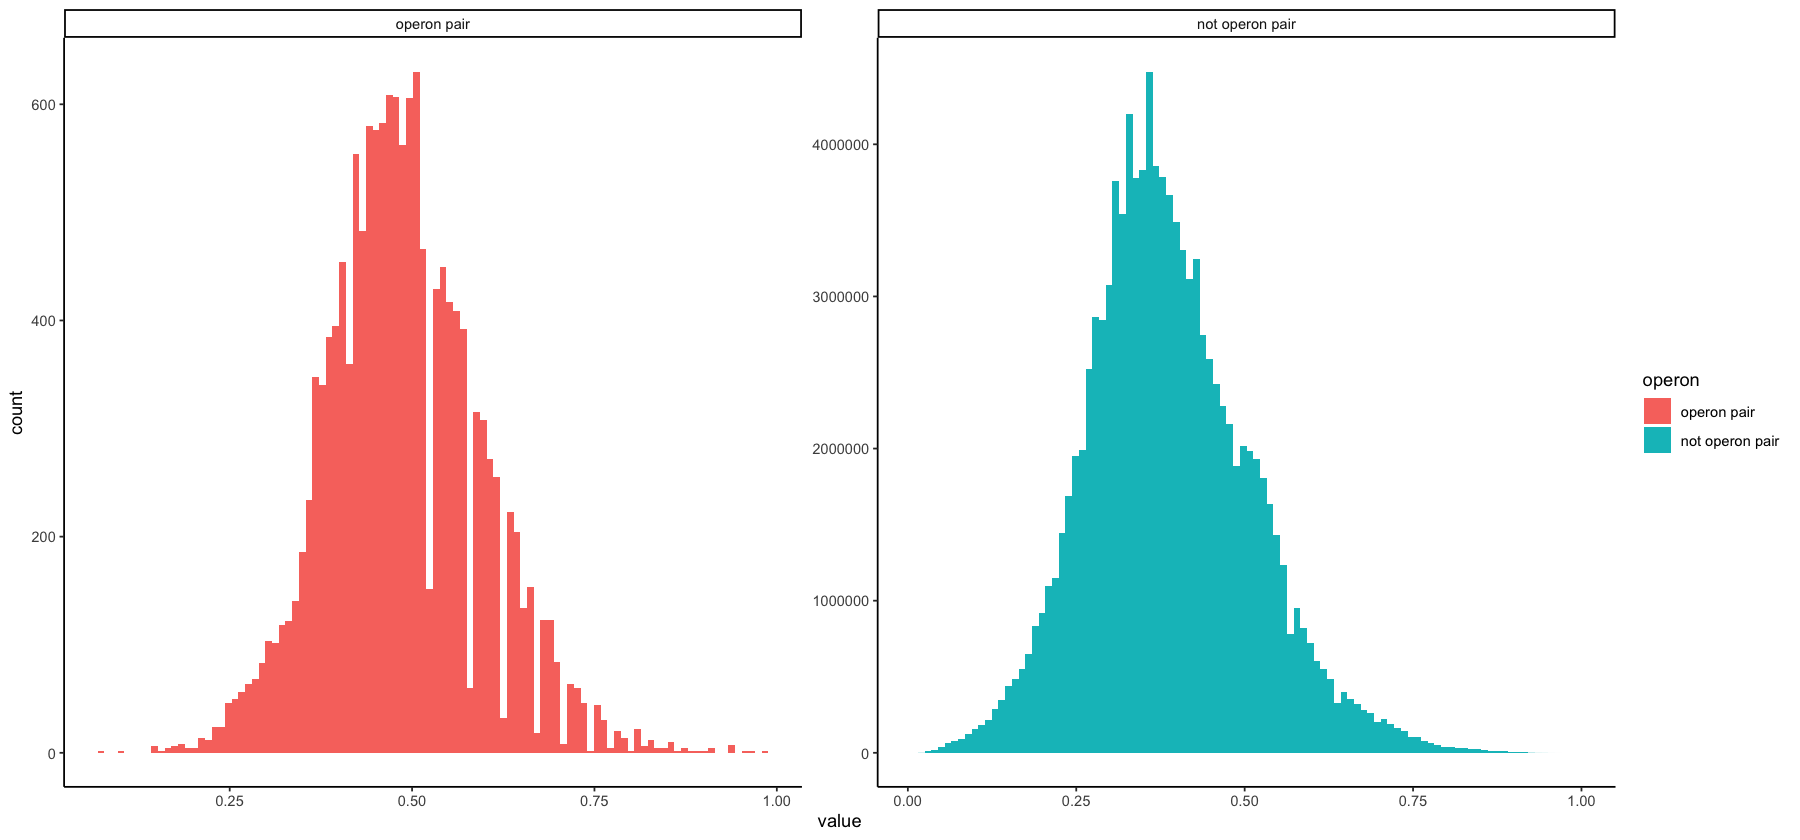

In [16]:
clustermatch_df$operon <- factor(clustermatch_df$operon, levels = c("operon pair", "not operon pair"))
ggplot(clustermatch_df, aes(x = value, fill = operon)) +
  geom_histogram(bins = 100) +
  theme_classic() +
  facet_wrap(~operon, scales = "free")

In [20]:
table(clustermatch_df$operon)


not operon pair     operon pair 
      108759492           14955 

In [21]:
clustermatch_df %>% 
  group_by(operon) %>%
  summarize(mean_value = mean(value),
            sd_value = sd(value))

operon,mean_value,sd_value
<chr>,<dbl>,<dbl>
not operon pair,0.3872488,0.1208564
operon pair,0.4858038,0.1054895
